# Unsupervised Learning

# 04_create_unsupervised_features

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 28/09/2025   | Adrienne | Created   | Created file for unsupervised learning | 
| 29/09/2025   | Martin | New   | Processing to apply the HCPCS code descriptions + EDA on the new descriptions | 

# Notes

- base model just a set of procedures - bare services to treat condition
- model with all procedures (so if you have 3 blood draws it it in there three times)
- Preventative care indicator
- columns for each hcpcs code range
- time between procedures?

# Content

* [Introduction](#introduction)
* [Load Data](#load-data)
* [Additional Features](#additional-features)
* [EDA](#eda)

# Introduction

In [3]:
%load_ext watermark

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [2]:
path = "../data/clean"
df = pd.read_pickle(f"{path}/patient_level.pkl")

In [5]:
df.head()

,patient_medicare_number,patient_first_name,patient_last_name,gender,birthdate,number_of_claims,drg_ls,combined_diagnosis_ls,combined_hcpcs_ls,billablePeriod_start_ls,billablePeriod_end_ls,location_of_bill_ls
0,1S00E00AD09,Oralia106,Ward668,female,1948-06-14,7,"[948, 003, 001]","[K011, G43719, R52, E669, E785, K3520, K37, Z9...","[99241, 00777310502, G0444, 00777310502, 99221...","[2019-05-17, 2019-10-14, 1991-01-11, 2014-01-1...","[2019-05-17, 2019-10-14, 1991-01-12, 2014-01-1...","[002, 002, 002, 002, 002]"
1,1S00E00AG56,Filomena21,Rice937,female,1947-05-04,3,[],"[E669, J329, E034, D649, E785, B349, E669, J32...","[99241, 00777310502, G0444, 00777310502, 99241...","[2019-07-07, 2017-08-27, 2020-07-06]","[2019-07-07, 2017-08-27, 2020-07-06]","[002, 002]"
2,1S00E00MP51,Errol226,Hilpert278,male,1948-01-01,2,[],"[C189, K621, D649, M810, I639, P292, K635, C18...","[G0152, 99241]","[2019-07-03, 2019-10-23]","[2019-07-03, 2019-10-23]","[004, 002]"
3,1S00E00JD02,Jacquetta1,Koepp521,female,1952-04-16,1,[],"[R739, E781, E8881, D649, M179, J329, E669, E119]",[99241],[2012-03-01],[2012-03-01],[002]
4,1S00E00HF72,Darlene91,Carter549,female,1947-08-12,3,[],"[O039, O039, B9789, O039]","[Q5001, 99241, G0444]","[2012-09-19, 2017-08-11, 2017-12-05]","[2012-09-19, 2017-08-11, 2017-12-05]","[004, 002]"


In [197]:
df.shape

(5158, 12)

# Additional Features

Focusing on transforming the HCPCS codes into a useable format for unsupervised learning.

- HCPCS
  - code
  - category
  - description

## Create the mappers

The mapper combines the various HCPCS encodings (compiled by Adrienne) in a single dataframe. It expands the coding range from `code_range_start` to `code_range_end` and maps it to the corresponding description.

In [137]:
mapper_path = "../data/mappers"
cpt_map = pd.read_csv(f"{mapper_path}/CPT_Category_II.csv")
hcpcs_1_map = pd.read_csv(f"{mapper_path}/HCPCS_Level_I.csv")
hcpcs_2_map = pd.read_csv(f"{mapper_path}/HCPCS_Level_II.csv")
hcpcs_detailed_map = pd.read_csv(f"{mapper_path}/HCPCS_Detailed.csv")

In [138]:
hcpcs_1_map.head()

,code_range_start,code_range_end,range_description
0,99201,99499,Evaluation and Management (E/M) Codes
1,100,1999,Anesthesia Codes
2,99100,99140,Anesthesia Codes
3,10021,69990,Surgery Codes
4,70010,79999,Radiology Codes


In [139]:
def extend_values(val: int, maxlen):
  if len(str(val)) < maxlen:
    return (maxlen - len(str(val))) * "0" + str(val)
  else:
    return str(val)

In [140]:
def create_mapper(raw: pd.DataFrame):
  out = {
    'code': [],
    'category': [],
    'description': []
  }
  for idx, row in raw.iterrows():
    if isinstance(row['code_range_start'], int):
      value = np.arange(row['code_range_start'], row['code_range_end']+1)
      value = list(map(lambda x: extend_values(x, 5), value))
      out['code'].append(value)
      out['category'].append(len(value) * ["HCPCS_level_1"])
      out['description'].append(len(value) * [row['range_description']])
    
    elif row['code_range_start'][0].isalpha():
      if pd.isna(row['code_range_end']):
        out['code'].append([row['code_range_start']])
        out['category'].append(["HCPCS_level_2"])
        out['description'].append([row['range_description']])
      else:
        try:
          start_letter = row['code_range_start'][0]
          start_num, end_num = int(row['code_range_start'][1:]), int(row['code_range_end'][1:])
          value = np.arange(start_num, end_num+1)
          value = list(map(lambda x: extend_values(x, 4), value))
          value = [f"{start_letter}{i}" for i in value]
          out['code'].append(value)
          out['category'].append(len(value) * ["HCPCS_level_2"])
          out['description'].append(len(value) * [row['range_description']])
        except:
          pass
    
    elif row['code_range_start'][-1].isalpha():
      try:
        end_letter = row['code_range_start'][-1]
        start_num, end_num = int(row['code_range_start'][:-1]), int(row['code_range_end'][:-1])
        value = np.arange(start_num, end_num+1)
        value = list(map(lambda x: extend_values(x, 4), value))
        value = [f"{i}{end_letter}" for i in value]
        out['code'].append(value)
        out['category'].append(len(value) * ["CPT"])
        out['description'].append(len(value) * [row['range_description']])
      except:
        pass

  out = {k: [i for sublist in v for i in sublist] for k, v in out.items()}
  out = pd.DataFrame(out)
  
  return out

In [141]:
hcpcs_1_map = create_mapper(hcpcs_1_map)
hcpcs_2_map = create_mapper(hcpcs_2_map)
cpt_map = create_mapper(cpt_map)

In [142]:
combined_mapper = pd.concat([hcpcs_1_map, hcpcs_2_map, cpt_map], axis=0)
combined_mapper.head()

,code,category,description
0,99201,HCPCS_level_1,Evaluation and Management (E/M) Codes
1,99202,HCPCS_level_1,Evaluation and Management (E/M) Codes
2,99203,HCPCS_level_1,Evaluation and Management (E/M) Codes
3,99204,HCPCS_level_1,Evaluation and Management (E/M) Codes
4,99205,HCPCS_level_1,Evaluation and Management (E/M) Codes


## Apply mapper to HCPCS lists

Using the mapper we can apply the additional columns with category and description to each column of HCPCS

In [143]:
maxlen = max(df['combined_hcpcs_ls'].str.len())
df_hcpcs = pd.DataFrame(df['combined_hcpcs_ls'].to_list(), columns=[f"hcpcs_{i}" for i in range(maxlen)])
df_hcpcs.head()

,hcpcs_0,hcpcs_1,hcpcs_2,hcpcs_3,hcpcs_4,hcpcs_5,hcpcs_6,hcpcs_7,hcpcs_8,hcpcs_9,...,hcpcs_331,hcpcs_332,hcpcs_333,hcpcs_334,hcpcs_335,hcpcs_336,hcpcs_337,hcpcs_338,hcpcs_339,hcpcs_340
0,99241,00777310502,G0444,00777310502,99221,00777310502,99241,00777310502,99221,00777310502,...,None,None,None,None,None,None,None,None,None,None
1,99241,00777310502,G0444,00777310502,99241,00777310502,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,G0152,99241,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,99241,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,Q5001,99241,G0444,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [144]:
df_hcpcs_combined = []
for i in range(maxlen):
  combined = df_hcpcs[[f"hcpcs_{i}"]].merge(
    combined_mapper,
    left_on=f"hcpcs_{i}",
    right_on="code",
    how='left'
  )
  combined = combined.drop(['code'], axis=1)
  combined = combined.rename({
    'category': f"category_{i}",
    'description': f"description_{i}",
  }, axis=1)
  df_hcpcs_combined.append(combined)

df_hcpcs_combined = pd.concat(df_hcpcs_combined, axis=1)
df_hcpcs_combined = df_hcpcs_combined.fillna(np.nan)

In [145]:
df_hcpcs_combined.head()

,hcpcs_0,category_0,description_0,hcpcs_1,category_1,description_1,hcpcs_2,category_2,description_2,hcpcs_3,...,description_337,hcpcs_338,category_338,description_338,hcpcs_339,category_339,description_339,hcpcs_340,category_340,description_340
0,99241,HCPCS_level_1,Evaluation and Management (E/M) Codes,00777310502,NaN,NaN,G0444,HCPCS_level_2,Procedures/Professional Services,00777310502,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,99241,HCPCS_level_1,Evaluation and Management (E/M) Codes,00777310502,NaN,NaN,G0444,HCPCS_level_2,Procedures/Professional Services,00777310502,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,G0152,HCPCS_level_2,Procedures/Professional Services,99241,HCPCS_level_1,Evaluation and Management (E/M) Codes,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,99241,HCPCS_level_1,Evaluation and Management (E/M) Codes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Q5001,HCPCS_level_2,Temporary Codes,99241,HCPCS_level_1,Evaluation and Management (E/M) Codes,G0444,HCPCS_level_2,Procedures/Professional Services,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Time interval between claims

Using `billablePeriod_end_ls`, sort and compare the time interval of days between each claim. Then expand it out into individual columns

In [146]:
def days_between_claim(item):
  sorted_dates = pd.to_datetime(pd.Series(item)).sort_values().reset_index(drop=True)
  return sorted_dates.diff().dt.days.dropna().astype(int).tolist()

In [200]:
day_interval = pd.DataFrame(df['billablePeriod_end_ls'].apply(days_between_claim))
day_maxlen = max(day_interval['billablePeriod_end_ls'].str.len())
df_day_interval = pd.DataFrame(day_interval['billablePeriod_end_ls'].to_list(), columns=[f"day_interval_{i}" for i in range(day_maxlen)])
df_day_interval.head()

,day_interval_0,day_interval_1,day_interval_2,day_interval_3,day_interval_4,day_interval_5,day_interval_6,day_interval_7,day_interval_8,day_interval_9,...,day_interval_73,day_interval_74,day_interval_75,day_interval_76,day_interval_77,day_interval_78,day_interval_79,day_interval_80,day_interval_81,day_interval_82
0,2318.0,81.0,8408.0,239.0,1705.0,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,679.0,365.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1787.0,116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# EDA

## Breakdown of procedures

NOTE: This is on the `claim_mini_sample` dataset (10,000 entries)

- Most common description of procedures done are:
  1. Evaluation and Management (E/M) Codes (HCPCS Level I)
  2. Procedures/Professional Services (HCPCS Level II)
- Other codes include
  1. Alcohol and Drug Abuse Treatment
  2. National Codes Established for State Medicaid Agencies

In [181]:
def countplot_with_labels(l, title):
  ax = sns.countplot(l, palette='pastel')

  for p in ax.patches:
    ax.text(
      p.get_width() + 1,
      p.get_y() + p.get_height() / 2,
      int(p.get_width()),
      ha="center",
      va="center",
      color="black",
      fontsize=12,
      fontweight="bold"
    )
  
  plt.title(title)

  return plt

In totality, what is the distribution of HCPCS codes across all claims

In [ ]:
all_hcpcs = df['combined_hcpcs_ls'].explode().reset_index()
all_hcpcs = all_hcpcs.merge(
  combined_mapper,
  left_on='combined_hcpcs_ls',
  right_on='code',
  how='left'
)
all_hcpcs = all_hcpcs.drop(['index', 'code'], axis=1)
all_hcpcs = all_hcpcs.fillna("Unknown")

C:\Users\User\AppData\Local\Temp\ipykernel_1032\2240585470.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(l, palette='pastel')


<module 'matplotlib.pyplot' from 'd:\\MADS\\SIADS 696 - Milestone II\\siads_696_mII\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

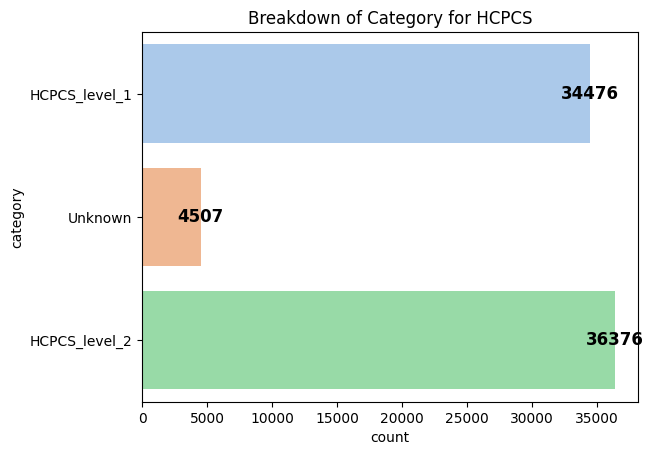

In [183]:
countplot_with_labels(all_hcpcs['category'], "Breakdown of Category for HCPCS")

C:\Users\User\AppData\Local\Temp\ipykernel_1032\2240585470.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(l, palette='pastel')


<module 'matplotlib.pyplot' from 'd:\\MADS\\SIADS 696 - Milestone II\\siads_696_mII\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

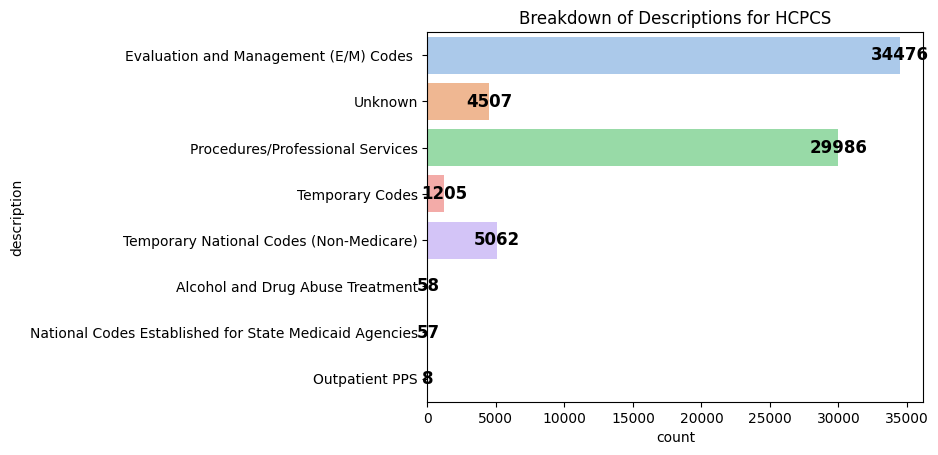

In [184]:
countplot_with_labels(all_hcpcs['description'], "Breakdown of Descriptions for HCPCS")

Compare for the first and second HCPCS, what are the most common category of procedures done

In [148]:
df_plot = df_hcpcs_combined[['description_0', 'description_1']]
df_plot.head()

,description_0,description_1
0,Evaluation and Management (E/M) Codes,NaN
1,Evaluation and Management (E/M) Codes,NaN
2,Procedures/Professional Services,Evaluation and Management (E/M) Codes
3,Evaluation and Management (E/M) Codes,NaN
4,Temporary Codes,Evaluation and Management (E/M) Codes


C:\Users\User\AppData\Local\Temp\ipykernel_1032\2240585470.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(l, palette='pastel')


<module 'matplotlib.pyplot' from 'd:\\MADS\\SIADS 696 - Milestone II\\siads_696_mII\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

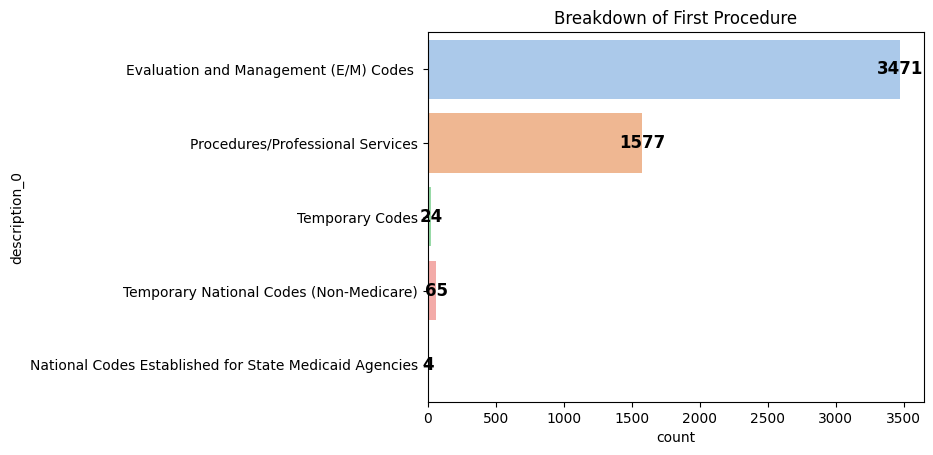

In [185]:
countplot_with_labels(df_plot['description_0'], "Breakdown of First Procedure")

C:\Users\User\AppData\Local\Temp\ipykernel_1032\2240585470.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(l, palette='pastel')


<module 'matplotlib.pyplot' from 'd:\\MADS\\SIADS 696 - Milestone II\\siads_696_mII\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

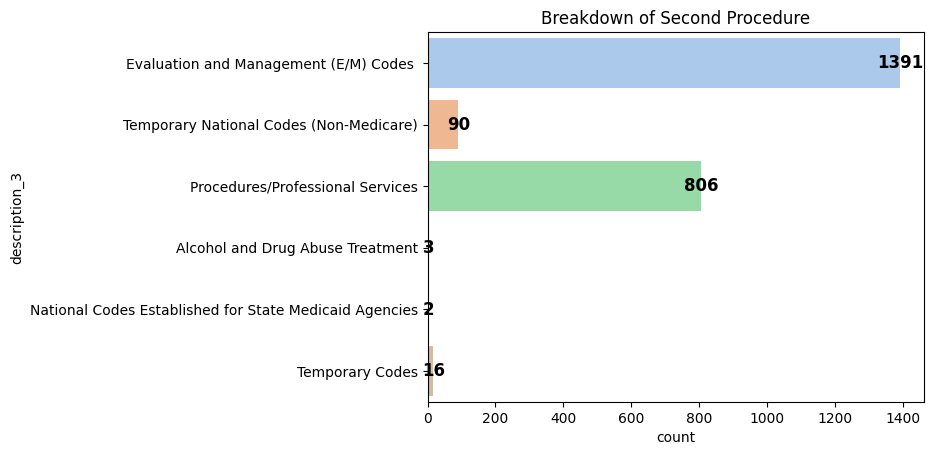

In [196]:
countplot_with_labels(df_hcpcs_combined['description_3'], "Breakdown of Second Procedure")

## How long between claim submissions

d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\numpy\lib\_histograms_impl.py:837: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
d:\MADS\SIADS 696 - Milestone II\siads_696_mII\.venv\Lib\site-packages\numpy\lib\_histograms_impl.py:838: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


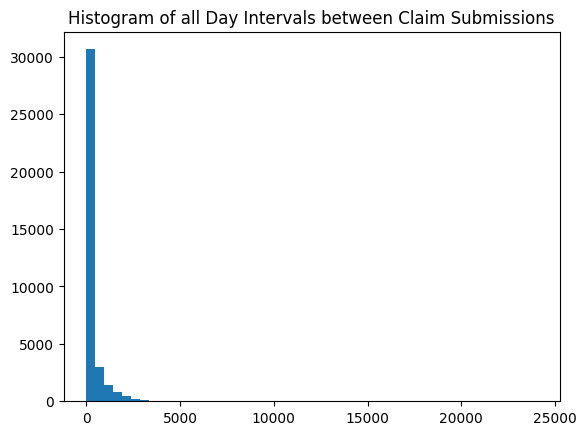

In [209]:
plt.hist(day_interval.explode('billablePeriod_end_ls'), bins=50)
plt.title("Histogram of all Day Intervals between Claim Submissions")
plt.show()

Text(0.5, 1.0, 'How long between the first and second claim submissions in Days')

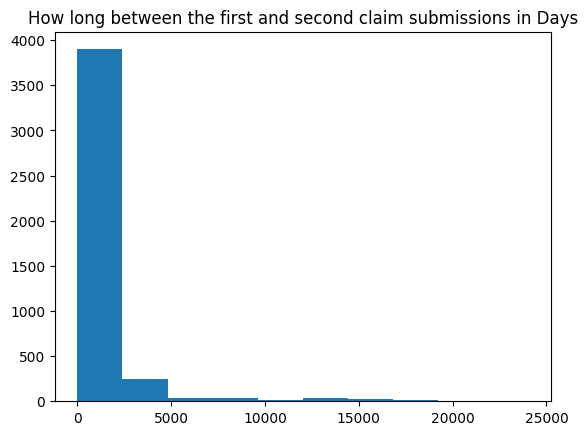

In [211]:
plt.hist(df_day_interval['day_interval_0'])
plt.title('How long between the first and second claim submissions in Days')

In [ ]:
%watermark